In [1]:
import numpy as np
import pandas as pd
import rdkit.Chem.AllChem as Chem
import dreams.utils.mols as mu
import dreams.utils.io as io
from tqdm import tqdm
tqdm.pandas()
from pathlib import Path
from matchms.importing import load_from_mgf
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve, RocCurveDisplay, roc_curve, average_precision_score
import matplotlib.pyplot as plt
from dreams.utils.plots import init_plotting, get_nature_hex_colors
from dreams.utils.plots import save_fig
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score, f1_score
from dreams.utils.plots import init_plotting
from dreams.utils.io import list_from_txt
from dreams.definitions import *
%load_ext autoreload
%autoreload 2

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


# SIRIUS

In [2]:
df_sirius = pd.read_csv('/Users/roman/sirius_projects/f_detection_mce/formula_identifications.tsv', sep='\t')
df_sirius

,rank,molecularFormula,adduct,precursorFormula,SiriusScore,TreeScore,IsotopeScore,numExplainedPeaks,explainedIntensity,medianMassErrorFragmentPeaks(ppm),medianAbsoluteMassErrorFragmentPeaks(ppm),massErrorPrecursor(ppm),lipidClass,ionMass,retentionTimeInSeconds,id
0,1,C20H31NO3,[M + O + H]+,C20H31NO4,4068.922087,4068.922087,0.0,24,0.981212,-2.291670,2.291670,-0.014059,Cer(d10:2_10:3),350.23258,NaN,5148_20231031_mce_library_pos_all_lib_MS2_clea...
1,2,C28H36O5,[M + H3N + H]+,C28H39NO5,3063.273543,3063.273543,0.0,26,0.921904,-1.380031,1.395057,0.000425,DG(10:3_15:6),470.29010,NaN,20396_20231031_mce_library_pos_all_lib_MS2_cle...
2,3,C20H31NO3,[M + O + H]+,C20H31NO4,3051.319069,3051.319069,0.0,17,1.000000,-2.440852,2.440852,-0.014059,Cer(d10:2_10:3),350.23258,NaN,5149_20231031_mce_library_pos_all_lib_MS2_clea...
3,4,C16H23NO3,[M + O + H]+,C16H23NO4,3048.230567,3048.230567,0.0,11,0.983830,-1.265639,1.265639,-0.015869,Cer(d8:2_8:3),294.16998,NaN,19833_20231031_mce_library_pos_all_lib_MS2_cle...
4,5,C28H36O5,[M + H3N + H]+,C28H39NO5,3046.603157,3046.603157,0.0,22,0.925164,-4.769864,4.769864,0.000425,DG(10:3_15:6),470.29010,NaN,20397_20231031_mce_library_pos_all_lib_MS2_cle...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20653,20092,C12H10N2O7S10,[M + H]+,C12H10N2O7S10,0.768784,0.768784,0.0,3,1.000000,0.656149,0.656149,0.232422,NaN,614.77693,NaN,7994_20231031_mce_library_pos_all_lib_MS2_clea...
20654,20093,C12H7N3O15S6,[M + H]+,C12H7N3O15S6,-0.075896,-0.075896,0.0,2,0.728428,1.597127,1.597127,0.640790,NaN,625.82782,NaN,7414_20231031_mce_library_pos_all_lib_MS2_clea...
20655,20093,C12H7N3O15S6,[M + H]+,C12H7N3O15S6,-0.079939,-0.079939,0.0,2,0.791402,1.833313,1.833313,0.640790,NaN,625.82782,NaN,7413_20231031_mce_library_pos_all_lib_MS2_clea...
20656,20094,C10H7NO6S10,[M + H]+,C10H7NO6S10,-0.373129,-0.373129,0.0,3,0.760309,-0.162586,0.162586,0.244917,NaN,557.75546,NaN,7001_20231031_mce_library_pos_all_lib_MS2_clea...


In [3]:
# F detection predictions and labels
df_sirius['gt_formula'] = df_sirius['id'].apply(lambda x: x.split('_')[-2])
df_sirius['real'] = df_sirius['gt_formula'].apply(mu.formula_to_dict).apply(lambda f: 'F' in f).astype(int)
df_sirius['SIRIUS pred'] = df_sirius['molecularFormula'].apply(mu.formula_to_dict).apply(lambda f: 'F' in f).astype(int)

In [4]:
df_sirius_1 = pd.read_csv('/Users/roman/sirius_projects/f_detection_mce_max1F/formula_identifications.tsv', sep='\t')
df_sirius_1 = df_sirius_1[['molecularFormula', 'id']]
df_sirius_1['SIRIUS pred (max F = 1)'] = df_sirius_1['molecularFormula'].apply(mu.formula_to_dict).apply(lambda f: 'F' in f).astype(int)
df_sirius_1 = df_sirius_1.drop(columns=['molecularFormula'])

In [5]:
df_sirius = df_sirius.merge(df_sirius_1, on='id')

In [6]:
df_sirius

,rank,molecularFormula,adduct,precursorFormula,SiriusScore,TreeScore,IsotopeScore,numExplainedPeaks,explainedIntensity,medianMassErrorFragmentPeaks(ppm),medianAbsoluteMassErrorFragmentPeaks(ppm),massErrorPrecursor(ppm),lipidClass,ionMass,retentionTimeInSeconds,id,gt_formula,real,SIRIUS pred,SIRIUS pred (max F = 1)
0,1,C20H31NO3,[M + O + H]+,C20H31NO4,4068.922087,4068.922087,0.0,24,0.981212,-2.291670,2.291670,-0.014059,Cer(d10:2_10:3),350.23258,NaN,5148_20231031_mce_library_pos_all_lib_MS2_clea...,C20H31NO4,0,0,0
1,2,C28H36O5,[M + H3N + H]+,C28H39NO5,3063.273543,3063.273543,0.0,26,0.921904,-1.380031,1.395057,0.000425,DG(10:3_15:6),470.29010,NaN,20396_20231031_mce_library_pos_all_lib_MS2_cle...,C28H39NO5,0,0,0
2,3,C20H31NO3,[M + O + H]+,C20H31NO4,3051.319069,3051.319069,0.0,17,1.000000,-2.440852,2.440852,-0.014059,Cer(d10:2_10:3),350.23258,NaN,5149_20231031_mce_library_pos_all_lib_MS2_clea...,C20H31NO4,0,0,0
3,4,C16H23NO3,[M + O + H]+,C16H23NO4,3048.230567,3048.230567,0.0,11,0.983830,-1.265639,1.265639,-0.015869,Cer(d8:2_8:3),294.16998,NaN,19833_20231031_mce_library_pos_all_lib_MS2_cle...,C16H23NO4,0,0,0
4,5,C28H36O5,[M + H3N + H]+,C28H39NO5,3046.603157,3046.603157,0.0,22,0.925164,-4.769864,4.769864,0.000425,DG(10:3_15:6),470.29010,NaN,20397_20231031_mce_library_pos_all_lib_MS2_cle...,C28H39NO5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20653,20092,C12H10N2O7S10,[M + H]+,C12H10N2O7S10,0.768784,0.768784,0.0,3,1.000000,0.656149,0.656149,0.232422,NaN,614.77693,NaN,7994_20231031_mce_library_pos_all_lib_MS2_clea...,C11H9I3N2O4,0,0,0
20654,20093,C12H7N3O15S6,[M + H]+,C12H7N3O15S6,-0.075896,-0.075896,0.0,2,0.728428,1.597127,1.597127,0.640790,NaN,625.82782,NaN,7414_20231031_mce_library_pos_all_lib_MS2_clea...,C19H11Cl2I2NO3,0,0,0
20655,20093,C12H7N3O15S6,[M + H]+,C12H7N3O15S6,-0.079939,-0.079939,0.0,2,0.791402,1.833313,1.833313,0.640790,NaN,625.82782,NaN,7413_20231031_mce_library_pos_all_lib_MS2_clea...,C19H11Cl2I2NO3,0,0,0
20656,20094,C10H7NO6S10,[M + H]+,C10H7NO6S10,-0.373129,-0.373129,0.0,3,0.760309,-0.162586,0.162586,0.244917,NaN,557.75546,NaN,7001_20231031_mce_library_pos_all_lib_MS2_clea...,C9H6I3NO3,0,0,0


In [7]:
# Retrieve original .mgf indices
df_sirius['i'] = df_sirius['id'].apply(lambda x: int(x.split('_')[0]) - 1)
print(df_sirius['i'].nunique())
sirius_idx = df_sirius['i'].unique().tolist()

20658


SIRIUS pred
Precision 0.4952782217056516
Recall 0.7143755238893545
Accuracy 0.7658534224029432
F1 score 0.584984984984985


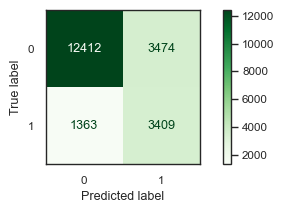

SIRIUS pred (max F = 1)
Precision 0.5167773192176566
Recall 0.6035205364626991
Accuracy 0.7780520863587956
F1 score 0.5567907201546641


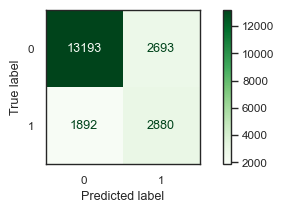

In [8]:
for col in df_sirius.columns:
    if not col.startswith('SIRIUS'):
        continue
    init_plotting(style='white')
    print(col)
    print('Precision', precision_score(df_sirius['real'], df_sirius[col]))
    print('Recall', recall_score(df_sirius['real'], df_sirius[col]))
    print('Accuracy', accuracy_score(df_sirius['real'], df_sirius[col]))
    print('F1 score', f1_score(df_sirius['real'], df_sirius[col]))
    cm = ConfusionMatrixDisplay.from_predictions(df_sirius['real'], df_sirius[col], cmap='Greens')

# DreaMS

In [12]:
df = pd.read_pickle(DATA_DIR / 'Pluskal_lab' / 'datasets' / '20231031_mce_library_pos_all_lib_MS2_clean_F_benchmark_dreams_preds_epoch=30_step=111000.pkl')
df

,PARSED PEAKS,description,FORMULA,inchi,inchiaux,SMILES,feature_id,mslevel,PRECURSOR TYPE,pepmass,...,retention_time,principal_investigator,data_collector,PRECURSOR M/Z,other_matched_compounds,other_matched_compounds_names,ROMol,matchms Spectrum,DreaMS_preds,label
0,"[[40.018111, 42.03373, 43.017761, 43.028978, 4...",MCE bioactive compounds library,C11H13N3O5,InChI=1S/C11H13N3O5/c1-2-11(18)6(5-15)19-9(8(1...,JFIWEPHGRUDAJN-DYUFWOLASA-N,C#C[C@@]1(O)[C@@H](CO)O[C@@H](n2ccc(N)nc2=O)[C...,-1,2,[M+H]+,"(268.0928, None)",...,69.34,Tomas Pluskal,Corinna Brungs,268.09280,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x2bca2e980>,"Spectrum(precursor m/z=268.09, 61 fragments be...",0.073493,0
1,"[[40.018208, 42.033733, 43.017761, 46.994873, ...",MCE bioactive compounds library,C11H13N3O5,InChI=1S/C11H13N3O5/c1-2-11(18)6(5-15)19-9(8(1...,JFIWEPHGRUDAJN-DYUFWOLASA-N,C#C[C@@]1(O)[C@@H](CO)O[C@@H](n2ccc(N)nc2=O)[C...,-1,2,[M+H]+,"(268.0928, None)",...,69.34,Tomas Pluskal,Corinna Brungs,268.09280,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x2c71b5620>,"Spectrum(precursor m/z=268.09, 39 fragments be...",0.890687,0
2,"[[40.018208, 42.033733, 43.017761, 46.994873, ...",MCE bioactive compounds library,C11H13N3O5,InChI=1S/C11H13N3O5/c1-2-11(18)6(5-15)19-9(8(1...,JFIWEPHGRUDAJN-DYUFWOLASA-N,C#C[C@@]1(O)[C@@H](CO)O[C@@H](n2ccc(N)nc2=O)[C...,412,2,[M+H]+,"(268.0928, None)",...,69.34,Tomas Pluskal,Corinna Brungs,268.09280,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x2c71b56c0>,"Spectrum(precursor m/z=268.09, 30 fragments be...",0.477284,0
5,"[[41.03848, 42.033739, 43.017724, 43.041538, 4...",MCE bioactive compounds library,C17H27NO3,InChI=1S/C17H27NO3/c1-11-6-5-9-17(2)15(21-17)1...,UJNSFDHVIBGEJZ-CMRIBGNTSA-N,C/C1=C/CC[C@@]2(C)O[C@@H]2[C@H]2OC(=O)[C@H](CN...,-1,2,[M+H]+,"(294.20637, None)",...,69.34,Tomas Pluskal,Corinna Brungs,294.20637,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x2bca2eb60>,"Spectrum(precursor m/z=294.21, 92 fragments be...",0.002169,0
6,"[[42.033739, 43.017743, 43.041538, 44.049385, ...",MCE bioactive compounds library,C17H27NO3,InChI=1S/C17H27NO3/c1-11-6-5-9-17(2)15(21-17)1...,UJNSFDHVIBGEJZ-CMRIBGNTSA-N,C/C1=C/CC[C@@]2(C)O[C@@H]2[C@H]2OC(=O)[C@H](CN...,-1,2,[M+H]+,"(294.20637, None)",...,69.34,Tomas Pluskal,Corinna Brungs,294.20637,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x2a26b6b10>,"Spectrum(precursor m/z=294.21, 61 fragments be...",0.008593,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48053,"[[56.049286, 59.04892, 70.064865, 83.060272, 8...",MCE bioactive compounds library,C25H29N9O3,InChI=1S/C25H29N9O3/c1-35-15-16-36-19-6-4-18(5...,DTYWJKSSUANMHD-UHFFFAOYSA-N,COCCOc1ccc(N2CCN(CCn3ncc4c3nc(N)n3nc(-c5ccco5)...,534,2,[M+H]+,"(504.24661, None)",...,111.94,Tomas Pluskal,Corinna Brungs,504.24661,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x2d5a970b0>,"Spectrum(precursor m/z=504.25, 33 fragments be...",0.044545,0
48061,"[[48.983977, 55.017835, 61.979147, 62.963146, ...",MCE bioactive compounds library,C20H13Cl2F2N3O5S,"InChI=1S/C20H13Cl2F2N3O5S/c1-33(29,30)27-9-2-4...",OKFDRAHPFKMAJH-UHFFFAOYSA-N,CS(=O)(=O)Nc1cc2c(cc1)oc1c(OC(F)F)ccc(C(=O)Nc3...,-1,2,[M+H]+,"(515.99938, None)",...,112.10,Tomas Pluskal,Corinna Brungs,515.99938,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x2d418f100>,"Spectrum(precursor m/z=516.00, 59 fragments be...",0.744644,1
48062,"[[163.966423, 181.052139, 225.042489, 226.0496...",MCE bioactive compounds library,C20H13Cl2F2N3O5S,"InChI=1S/C20H13Cl2F2N3O5S/c1-33(29,30)27-9-2-4...",OKFDRAHPFKMAJH-UHFFFAOYSA-N,CS(=O)(=O)Nc1cc2c(cc1)oc1c(OC(F)F)ccc(C(=O)Nc3...,-1,2,[M+H]+,"(515.99938, None)",...,112.10,Tomas Pluskal,Corinna Brungs,515.99938,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x2d5a7f150>,"Spectrum(precursor m/z=516.00, 16 fragments be...",0.409527,1
48063,"[[163.966418, 181.052139, 225.042489, 226.0496...",MCE bioactive compounds library,C20H13Cl2F2N3O5S,"InChI=1S/C20H13Cl2F2N3O5S/c1-33(29,30)27-9-2-4...",OKFDRAHPFKMAJH-UHFFFAOYSA-N,CS(=O)(=O)Nc1cc2c(cc1)oc1c(OC(F)F)ccc(C(=O)Nc3..

In [13]:
df = df.iloc[sirius_idx]
assert (df_sirius['gt_formula'].reset_index(drop=True) == df['FORMULA'].reset_index(drop=True)).all()
for c in df_sirius.columns:
    if c.startswith('SIRIUS'):
        df[c] = df_sirius[c].tolist()
df['real'] = df['FORMULA'].apply(mu.formula_to_dict).apply(lambda f: 'F' in f).astype(int)

/var/folders/73/x57b4d9x09qbcqjjd5ccz_6r0000gn/T/ipykernel_5853/3716745158.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df_sirius[c].tolist()
/var/folders/73/x57b4d9x09qbcqjjd5ccz_6r0000gn/T/ipykernel_5853/3716745158.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df_sirius[c].tolist()
/var/folders/73/x57b4d9x09qbcqjjd5ccz_6r0000gn/T/ipykernel_5853/3716745158.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [14]:
from dreams.utils.dformats import to_A_format
df = to_A_format(df.reset_index(drop=True), reset_index=False)
len(df)

Initial size: 20658
1 <= charge <= 1: 20658
Precursor m/z <= 1000.0: 20658
Intensity amplitude >= 20.0: 19622
Num. high (>= 0.1) peaks >= 3: 17052
Filtered size: 17052


17052

In [15]:
df['real'].value_counts()

real
0    13152
1     3900
Name: count, dtype: int64

In [16]:
df[df['real'] == 1]['SMILES'].nunique(), df[df['real'] == 0]['SMILES'].nunique()

(1175, 4055)

In [17]:
df['#F'] = df['FORMULA'].apply(lambda f: mu.formula_to_dict(f)['F'])
df['#F'].value_counts()

#F
0    13152
1     1598
3     1171
2      729
4      206
6      126
5       70
Name: count, dtype: int64

In [18]:
(df[df['#F'] > 5]['DreaMS_preds'] > 0.75).sum(), (df[df['#F'] > 5]['SIRIUS pred'] > 0.75).sum()

(54, 90)

SIRIUS pred Precision 0.4932467088391178 Recall 0.7397435897435898
SIRIUS pred (max F = 1) Precision 0.5125289534638872 Recall 0.6241025641025642


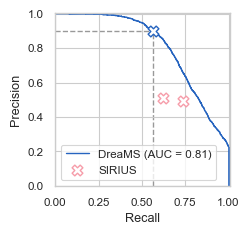

In [46]:
palette = get_nature_hex_colors()
init_plotting(figsize=(2.25, 2.25))

df_plot = df

color1 = palette[2]
color2 = palette[0]

fig, ax = plt.subplots()
# PrecisionRecallDisplay.from_predictions(df['real'], df['DreaMS_preds'], name='DreaMS', zorder=1, ax=ax)
precision, recall, thresholds = precision_recall_curve(df_plot['real'], df_plot['DreaMS_preds'])
plt.plot(recall, precision, zorder=1, color=color2, linewidth=1)
for c in df_sirius.columns:
    if c.startswith('SIRIUS'):
        prec, rec = precision_score(df_plot['real'], df_plot[c]), recall_score(df_plot['real'], df[c])
        # plt.plot(recall, precision, zorder=1, color=color1, linewidth=1)
        print(c, 'Precision', prec, 'Recall', rec)
        plt.scatter(rec, prec, marker='X', s=60, color=color1, facecolors='white', linewidth=1)

# plt.scatter([0.72], [0.4798452768729642], marker='o', s=40, color=color1, facecolors='white', linewidth=1)
# plt.scatter([0.519], [0.899], marker='o', s=40, color=color2, facecolors='white', linewidth=1)  # thld = 0.91419804

plt.vlines(1, 0, min(precision), color=color2)

plt.hlines(0.899, 0, 0.566, color='grey', linestyle='--', zorder=0, linewidth=1, alpha=0.8)
# plt.vlines(0.72, 0, 0.4798452768729642, color='grey', linestyle='--', zorder=0, linewidth=1, alpha=0.8)
# plt.hlines(0.4798452768729642, 0, 0.72, color='grey', linestyle='--', zorder=0, linewidth=1, alpha=0.8)
plt.vlines(0.566, 0, 0.899, color='grey', linestyle='--', zorder=0, linewidth=1, alpha=0.8)
plt.scatter(0.566, 0.899, marker='X', s=60, color=color2, facecolors='white', linewidth=1)

# plt.text(0.45182237 - 0.25, 0.9493838 - 0.14, '(0.5, 0.9)', color=color2)
# plt.text(0.71 - 0.32, 0.50 - 0.13, '(0.71, 0.50)', color=color1)
plt.xlim((0, 1.006))
plt.ylim((0, 1.006))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend([f'DreaMS (AUC = {average_precision_score(df["real"], df["DreaMS_preds"]):.2f})', 'SIRIUS'], loc='lower left')
save_fig('F_detection_prc.svg')
plt.show()

In [35]:
prec_thld = 0.9

# Thld precision on positive class
i = np.where((precision > prec_thld - 0.001) & (precision < prec_thld + 0.001))[0][0]
print(f'P: {precision[i]:.3f}, R: {recall[i]:.3f}, thld: {thresholds[i]}')
thld_prec_at_thld = thresholds[i]

# Thld precision on negative class
precision_neg, recall_neg, thresholds_neg = precision_recall_curve(1 - df_plot['real'], 1 - df_plot['DreaMS_preds'])
i = np.where((precision_neg > prec_thld - 0.001) & (precision_neg < prec_thld + 0.001))[0][0]
print(f'P: {precision_neg[i]:.3f}, R: {recall_neg[i]:.3f}, thld: {thresholds_neg[i]}')
thld_neg_prec_at_thld = thresholds_neg[i]

P: 0.899, R: 0.566, thld: 0.7524259686470032
P: 0.899, R: 0.961, thld: 0.4620896577835083


In [22]:
print('Uncertain percentage:', ((df['DreaMS_preds'] > thld_neg_prec_at_thld) & (df['DreaMS_preds'] < thld_prec_at_thld)).sum() / len(df))

Uncertain percentage: 0.04480412854797091


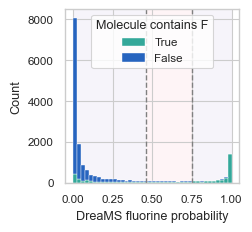

In [44]:
import seaborn as sns
from matplotlib.patches import Rectangle
init_plotting(figsize=(2.25, 2.25))
fig, ax = plt.subplots()

colors = get_nature_hex_colors() + ['#8079C4']

thld1, thld2 = thld_neg_prec_at_thld, thld_prec_at_thld

ylim = 15000  # arbitrary > max count
sns.histplot(data=df, x='DreaMS_preds', hue='real', binwidth=0.025, multiple='stack', ax=ax, palette=[colors[0], colors[1]], alpha=1, zorder=1)
plt.legend(['True', 'False'], title='Molecule contains F', loc='upper center')
ax.add_patch(Rectangle((thld2, 0), 1 - thld2, ylim, facecolor=colors[4], alpha=0.1, zorder=0))
ax.add_patch(Rectangle((0, 0), thld1, ylim, facecolor=colors[4], alpha=0.1, zorder=0))
ax.add_patch(Rectangle((thld1, 0), thld2 - thld1, ylim, facecolor=colors[2], alpha=0.1, zorder=0))
plt.axvline(x=thld1, linestyle='--', color='grey', zorder=1, linewidth=1)
plt.axvline(x=thld2, linestyle='--', color='grey', zorder=1, linewidth=1)
# plt.ylim(0, ylim)
plt.grid(zorder=0)
plt.xlabel('DreaMS fluorine probability')
save_fig('F_detection_hist.svg')
plt.show()

### Generalization case study

In [24]:
df_train = pd.read_pickle(MERGED_DATASETS / 'NIST20_MoNA_A_all_with_F_Murcko_split_MCE_test.pkl')
df_train = df_train[df_train['fold'] == 'train']
df_train = df_train.drop_duplicates(subset=['SMILES'])

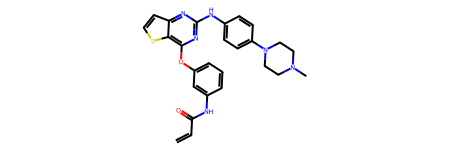

'C=CC(=O)Nc1cc(Oc2c3sccc3nc(Nc3ccc(N4CCN(C)CC4)cc3)n2)ccc1'

100%|██████████| 27701/27701 [00:03<00:00, 9181.84it/s]


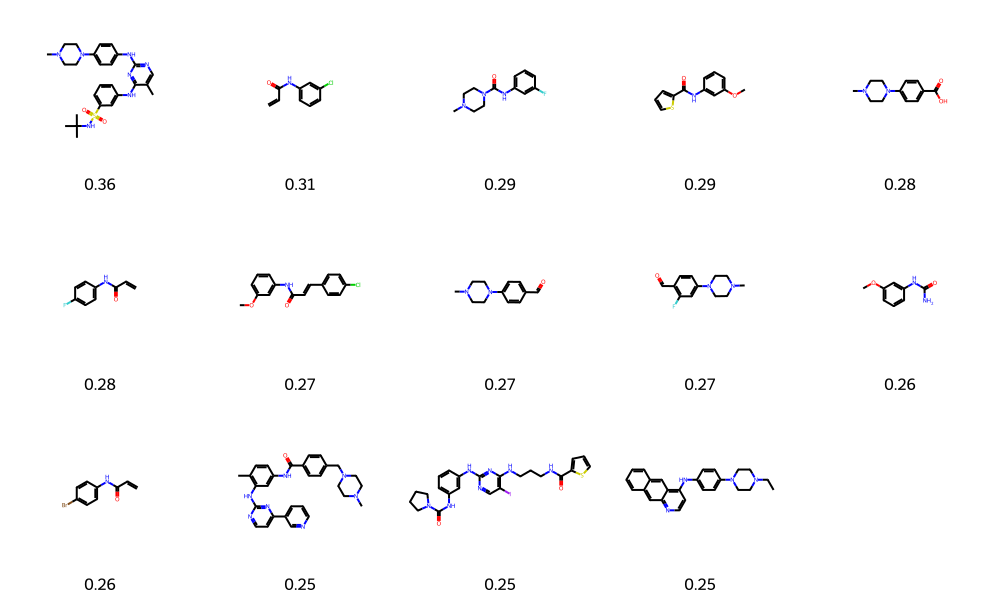

['Cc1cnc(Nc2ccc(N3CCN(C)CC3)cc2)nc1Nc1cccc([S@SP](=O)(=O)NC(C)(C)C)c1', 'C=CC(=O)Nc1cccc(Cl)c1', 'CN1CCN(C(=O)Nc2cccc(F)c2)CC1', 'COc1cccc(NC(=O)c2cccs2)c1', 'CN1CCN(c2ccc(C(=O)O)cc2)CC1', 'C=CC(=O)Nc1ccc(F)cc1', 'COc1cccc(NC(=O)/C=C/c2ccc(Cl)cc2)c1', 'CN1CCN(c2ccc(C=O)cc2)CC1', 'CN1CCN(c2ccc(C=O)c(F)c2)CC1', 'COc1cccc(NC(N)=O)c1', 'C=CC(=O)Nc1ccc(Br)cc1', 'Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc(-c2cccnc2)n1', 'O=C(NCCCNc1nc(Nc2cccc(NC(=O)N3CCCC3)c2)ncc1I)c1cccs1', 'CCN1CCN(c2ccc(Nc3ccnc4cc5ccccc5cc34)cc2)CC1']


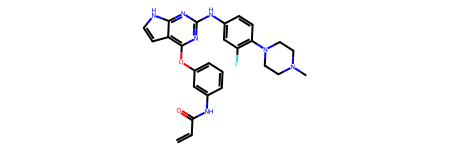

'C=CC(=O)Nc1cc(Oc2c3cc[nH]c3nc(Nc3cc(F)c(N4CCN(C)CC4)cc3)n2)ccc1'

100%|██████████| 27701/27701 [00:03<00:00, 9068.95it/s]


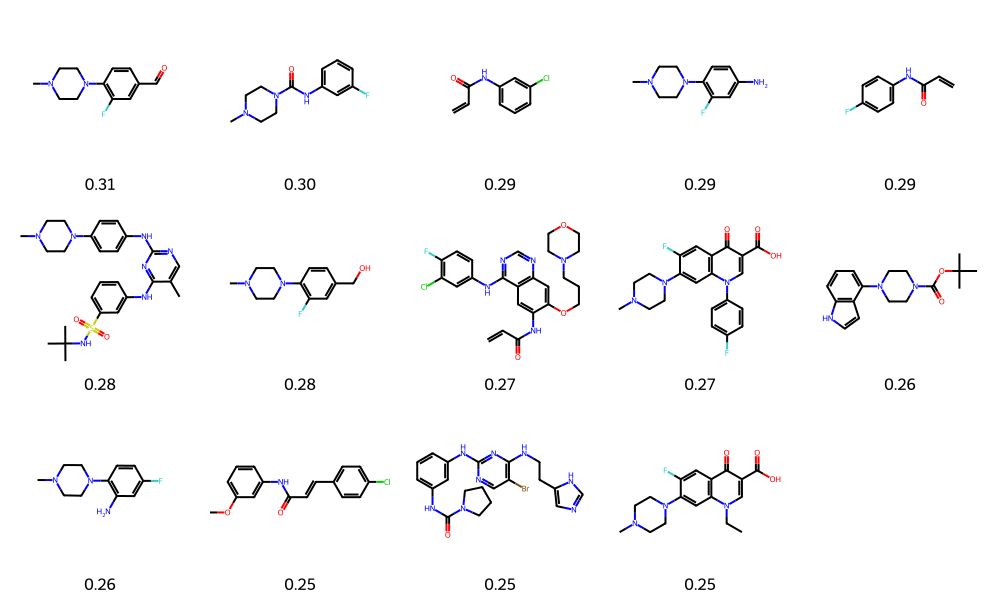

['CN1CCN(c2ccc(C=O)cc2F)CC1', 'CN1CCN(C(=O)Nc2cccc(F)c2)CC1', 'C=CC(=O)Nc1cccc(Cl)c1', 'CN1CCN(c2ccc(N)cc2F)CC1', 'C=CC(=O)Nc1ccc(F)cc1', 'Cc1cnc(Nc2ccc(N3CCN(C)CC3)cc2)nc1Nc1cccc([S@SP](=O)(=O)NC(C)(C)C)c1', 'CN1CCN(c2ccc(CO)cc2F)CC1', 'C=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OCCCN1CCOCC1', 'CN1CCN(c2cc3c(cc2F)c(=O)c(C(=O)O)cn3-c2ccc(F)cc2)CC1', 'CC(C)(C)OC(=O)N1CCN(c2cccc3[nH]ccc23)CC1', 'CN1CCN(c2ccc(F)cc2N)CC1', 'COc1cccc(NC(=O)/C=C/c2ccc(Cl)cc2)c1', 'O=C(Nc1cccc(Nc2ncc(Br)c(NCCc3cnc[nH]3)n2)c1)N1CCCC1', 'CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCN(C)CC3)cc21']


In [29]:
idx = [14236, 4924]
for i in idx:
    mol = df.loc[i, 'ROMol']
    display(mol)
    display(df.loc[i, 'SMILES'])
    df_train['sim to i'] = df_train['ROMol'].progress_apply(lambda m: mu.morgan_mol_sim(mol, m))
    df_train = df_train.sort_values(by='sim to i', ascending=False)
    display(mu.show_mols(
        df_train['ROMol'][:14].tolist(), df_train['sim to i'][:14].tolist(),
        legend_float_decimals=2, mols_per_row=5, save_pth=None#, svg=True, save_pth=FIGURES / 'F_detection_case_study_closest_from_train.svg'
    ))
    print(df_train['SMILES'][:14].tolist())

487.19107
0.009543606080114841


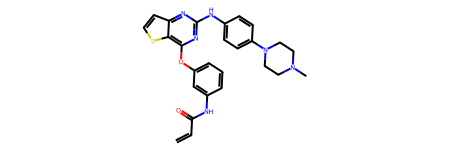

488.22048
0.9469178318977356


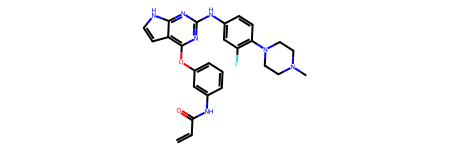

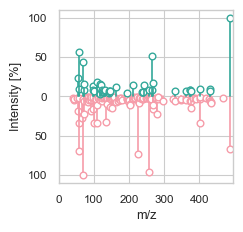

In [32]:
import dreams.utils.spectra as su
from dreams.utils.plots import get_nature_hex_colors

for i in idx:
    print(df.loc[i, 'PRECURSOR M/Z'])
    print(df.loc[i, 'DreaMS_preds'])
    display(df.loc[i, 'ROMol'])

colors = get_nature_hex_colors()
colors = [colors[1], colors[0], colors[2]]

su.plot_spectrum(df.loc[idx[0]]['PARSED PEAKS'], mirror_spec=df.loc[idx[1]]['PARSED PEAKS'], figsize=(2.25, 2.25), colors=colors, save_pth=FIGURES / 'F_detection_case_study_spec.svg')